## Supplementary: FC inter vs SC intra
Create a figure identical to the one in the paper, but using FC inter vs SC intra instead of SC intra vs SC inter.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import itertools 

# ignore warnings for easier plotting
import warnings
warnings.filterwarnings("ignore")

from load_data import load_data

In [2]:
sns.set(style='darkgrid', context='talk', palette='Set1', font="serif")

In [3]:
# Hue colors order and names
# auxiliar dict to put correct order in the figure
map_hue_color = {
    "EDSS_group": ["EDSS<3", "EDSS>=3"],
    "SDMT_group": ["SDMT>=40", "SDMT<40"],
    "G_norm": ['G_z<=0', 'G_z>0'], 
    "Corr_norm": ['C_z<=0', 'C_z>0'],
    "disease": ["HC", "MS"],
    "GROUP": ["HC", "CIS", "RRMS", "SPMS", "PPMS"],
    "CENTER": ["CLINIC", "MAINZ", "MILAN", "NAPLES", "OSLO", "LONDON", "AMSTERDAM"],
    "groups" : ["HC", "EDSS<3", "EDSS>=3", "SDMT>=40", "SDMT<40"]
    # "GROUP": ["HC", "RRMS", "SPMS", "PPMS"]
}

# get the progressives together.
mapping_prog = {
    "HC": "HC",
    "CIS": "CIS", 
    "RRMS": "RRMS", 
    "SPMS": "PMS", 
    "PPMS": "PMS"
}

df_merged = load_data()
print(df_merged.columns.values)

['SubjID' 'DOB' 'SEX' 'GROUP' 'ONSET_DATE' 'MR_DATE' 'TREATMENT_AT_MRI'
 'TREATMENT' 'EDSS' 'YED' 'SDMT' 'RAO_SRTS' 'RAO_SRTR' 'RAO_SRTD'
 'RAO_10_36_SRTR' 'RAO_10_36_SRTD' 'RAO_WLG' 'RAO_PASAT' 'CENTER'
 'FMRI_TR' 'FMRI_NSCANS' 'FMRI_SCANTIME' 'AGE' 'DD' 'BICAMS_CVLT2'
 'BICAMS_BVMTR' 'NPS_x' '9HPT_dH' '9HPT_ndH' 'T25FW' 'motor_x'
 'Datecognitiveevaluation' 'TypeRAO' 'RAO_PASAT2sec'
 'RAO_WLGperseveration' 'RAO_WLGintrusion' 'Right9HPT' 'Left9HPT'
 'MFIS_TOTAL' 'MFIS_PHYS_FUNCT' 'MFIS_COGN_FUNCT' 'MFIS_SOCIAL_FUNCT'
 'BDI_II' '9HPT_average' 'notes_NPS' '9HPT_dH_' 'DWI_PROT' 'SCANNER'
 'SRTL_sum' 'PASAT2' 'WRDLG' 'QC' 'CENTER2' 'GM' 'GMF' 'WM' 'WMF' 'CSF'
 'CSFF' 'LV' 'LVF' 'BPF' 'RDwm_mean' 'RDwm_std' 'RDlwm_mean' 'RDlwm_std'
 'RDl_mean' 'RDl_std' 'RD_gm' 'RD_gmwm' 'Meta_x' 'Meta_noreg'
 'Unnamed: 21' 'Unnamed: 22' 'Unnamed: 23' 'FAwm_mean' 'FAwm_std'
 'FAlwm_mean' 'FAlwm_std' 'FAl_mean' 'FAl_std' 'FA_gm' 'FA_gmwm'
 'CC_Sag_area' 'CC_Posterior' 'CC_Mid_Posterior' 'CC_Central'
 'CC_Mid

In [4]:
print(len(df_merged))
x1 = "Comm_ratio"
x2 = "CC_ratio_area"

y1 = "FC_avg_spl"
y2 = "FC_efficiency"


tidy = (
    df_merged[["Comm_ratio", "CC_ratio_area", "FC_avg_spl", "FC_efficiency"]].stack() # pull the columns into row variables   
      .to_frame() # convert the resulting Series to a DataFrame
      .reset_index() # pull the resulting MultiIndex into the columns
      .rename(columns={0: 'val'}) # rename the unnamed column
)

print(tidy.head())


697
   level_0        level_1       val
0        0     Comm_ratio  0.010277
1        0  CC_ratio_area  0.221946
2        0     FC_avg_spl  0.611311
3        0  FC_efficiency  1.932505
4        1     Comm_ratio  0.010640


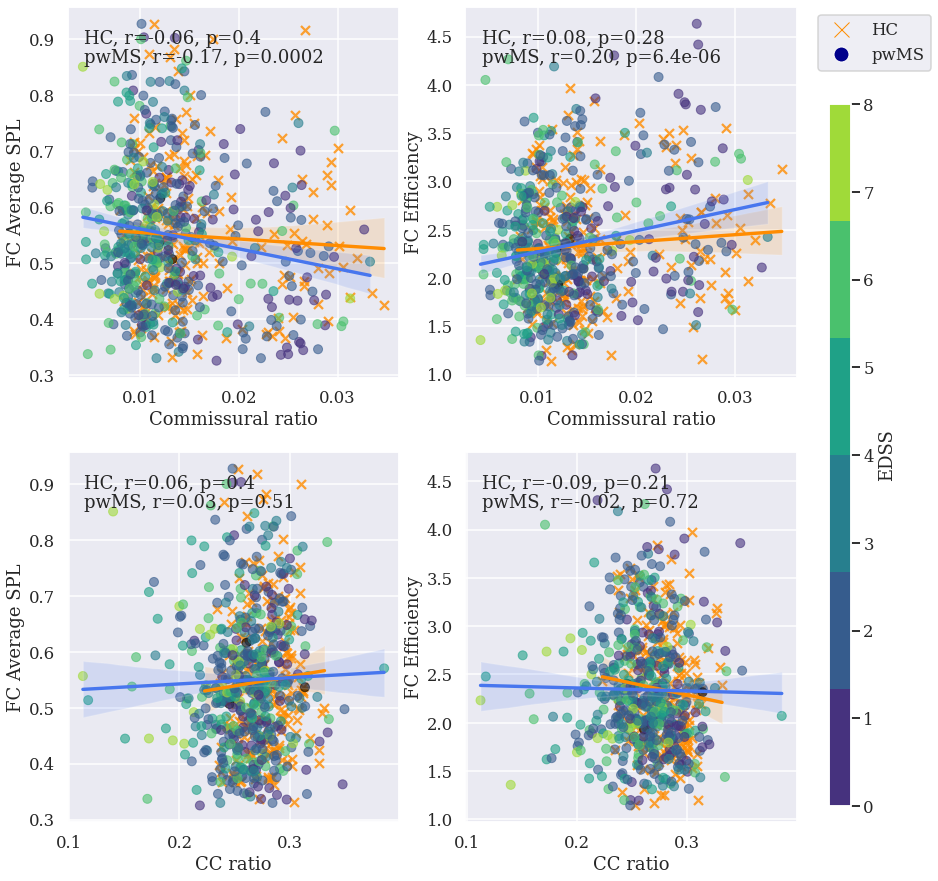

In [5]:
def annotate_axis(col1, col2, data, ax, label, level=0):
    """
    Version of the annotator function but
    for 

    """
    r, p = stats.pearsonr(data[col1], data[col2])

    # hardcoded, udpate if working with other labels
    x_pos = 0.05 
    y_pos = 0.9 - level*0.05

    ax.text(x_pos, y_pos, f'{label}, ' + 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("viridis"))

def create_subplot(x, y, ax, df, title, xlabel, ylabel, legend=True):
    ## Comm ratio - SPL
    # HC
    df_merged_hc = df_merged[df.disease=="HC"]
    sns.regplot(x=x, y=y, data=df_merged_hc, scatter_kws={"alpha": 0.8}, marker='x', color='darkorange', ax=ax)

    # pwMS
    df_merged_pwms = df_merged[df.disease!="HC"]

    EDSS_norm =(df_merged_pwms.EDSS-df_merged_pwms.EDSS.min())/(df_merged_pwms.EDSS.max()-df_merged_pwms.EDSS.min())
    df_merged_pwms_EDSS = [cmap(x) for x in EDSS_norm]
    color_array = np.array([*df_merged_pwms_EDSS])

    sns.regplot(x=x, y=y, data=df_merged_pwms, scatter_kws={"color": color_array, "alpha": 0.6}, marker='o', ax=ax)

    # annotate
    annotate_axis(x, y, df_merged_hc, ax, "HC", 0)
    annotate_axis(x, y, df_merged_pwms, ax, "pwMS", 1)

    # Title and axis
    # ax.set_title("Comm. ratio - SPL")
    #ax.set_xlabel("Commissural ratio")
    #ax.set_ylabel("Average SPL")
    from matplotlib.lines import Line2D
    handles = [Line2D([0], [0], markerfacecolor='darkorange', color='darkorange', marker='x', lw=0, markersize=15),
     Line2D([0], [0], marker='o', markerfacecolor='darkblue', lw=0, color='w', markersize=15)]
    if legend: ax.legend(handles=handles, labels=['HC', 'pwMS'], bbox_to_anchor=(1.04, 1), loc="upper left")

x1 = "Comm_ratio"
x2 = "CC_ratio_area"

y1 = "FC_avg_spl"
y2 = "FC_efficiency"


## Second version
# Don't use lmplot, its shite
# use subplot, and for each axis plot the things separately
sns.set(style='darkgrid', context='talk', palette='turbo', font="serif")
f, axes = plt.subplots(2, 2, figsize=(15,15), constrained_layout=True)
axes = axes.ravel()

## Comm ratio - Average SPL
create_subplot(x1, y1, axes[0], df_merged, "Comm. ratio - FC SPL", "Commissural ratio", "FC Average SPL", False)

## Comm ratio - Efficiency
create_subplot(x1, y2, axes[1], df_merged, "Comm. ratio - FC Efficiency", "Commissural ratio", "FC Efficiency")

## Comm ratio - Average SPL
create_subplot(x2, y1, axes[2], df_merged, "CC ratio - FC SPL", "CC ratio", "FC Average SPL", False)

## Comm ratio - Efficiency
create_subplot(x2, y2, axes[3], df_merged, "CC ratio - FC Efficiency", "CC ratio", "FC Efficiency", False)

## set the appropiate axis names
axes[0].set_xlabel("Commissural ratio")
axes[0].set_ylabel("FC Average SPL")

axes[1].set_xlabel("Commissural ratio")
axes[1].set_ylabel("FC Efficiency")

axes[2].set_xlabel("CC ratio")
axes[2].set_ylabel("FC Average SPL")

axes[3].set_xlabel("CC ratio")
axes[3].set_ylabel("FC Efficiency")


## LEGENDS
# Need to one one for colors and one for markers
# the one for colors needs to be a colorbar
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.83, 0.14, 0.02, 0.65])

# and the other one just a classic legend
import matplotlib as mpl
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=df_merged.EDSS.min(), vmax=df_merged.EDSS.max()), cmap=cmap),
             cax=cbar_ax, orientation='vertical', label='EDSS')

plt.savefig("/home/gerard/PAPERS/PAPER_COBRA/FIGURES/Suppl_Figure_Intraiter.png", dpi=300)
